In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss
import pandas as pd
import glob
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

In [3]:
fs = 2500
half_window_size = int(0.1*fs/2.)    

In [4]:
X = list()
y = list()
file_list = glob.glob(os.path.join('data', 'processed', '*'))

for f in file_list:
    df = pd.read_pickle(f)
    
    X_raw = np.array(df['LFP'])
    cand_loc = np.array(df['ripple_cand'])
    true_loc = np.array(df['ripple_true'])
    cand_index = np.argwhere(cand_loc==1)
    true_index = np.argwhere(true_loc==1)
    print(cand_index.shape, true_index.shape)
    
    for counter, index in enumerate(cand_index):
        X.append(X_raw[int(index-half_window_size):int(index+half_window_size)])
        if index in true_index:
            y.append(np.array([0,1]))
        else:
            y.append(np.array([1,0]))
            
X = np.array(X)
y = np.array(y)

X = np.expand_dims(X, axis=-1)
np.sum(y, axis=0)[1]/y.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(418, 1) (113, 1)
(269, 1) (121, 1)
(187, 1) (111, 1)
(418, 1) (113, 1)
(214, 1) (130, 1)


In [5]:
X.shape

(1506, 250, 1)

In [6]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

def decode(value, threshold=0.992):
    mask = value[:,1]>threshold
    y_pred_int = np.array(mask, dtype=int)
    return y_pred_int

Using TensorFlow backend.


In [7]:
def generate_model_CNN(input_shape, padding='same'):
    keras.backend.clear_session()

    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.GaussianNoise(0.1)(input_layer)

    x = keras.layers.Conv1D(filters=20,kernel_size=7,padding=padding,
                                activation='relu')(x)
    x = keras.layers.AveragePooling1D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GaussianNoise(0.1)(x)


    x = keras.layers.Conv1D(filters=20,kernel_size=7,padding=padding,
                                activation='relu')(x)
    x = keras.layers.AveragePooling1D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GaussianNoise(0.1)(x)

    x = keras.layers.Conv1D(filters=20,kernel_size=7,padding=padding,
                                activation='relu')(x)
    x = keras.layers.AveragePooling1D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GaussianNoise(0.1)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(50)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(50)(x)

    output_layer = keras.layers.Dense(units=2,activation='softmax')(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=['categorical_crossentropy'],
                  optimizer=keras.optimizers.Adam(lr=0.005),
                  metrics=['accuracy'],
                  )

    return model

In [8]:
model = generate_model_CNN(input_shape=X[0].shape)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 1)            0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 250, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 20)           160       
_________________________________________________________________
average_pooling1d_1 (Average (None, 125, 20)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 20)           80        
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 125, 20)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 20)           2820

In [9]:
class_weight = {0: 1., 1: 5.,}

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size=32,
                    epochs=50,
                    class_weight=class_weight,
                   )

Train on 1204 samples, validate on 302 samples
Epoch 1/50
1204/1204 [==============================] - 2s 1ms/step - loss: 1.3975 - accuracy: 0.6171 - val_loss: 0.6564 - val_accuracy: 0.6755
Epoch 2/50
1204/1204 [==============================] - 1s 561us/step - loss: 0.8921 - accuracy: 0.7425 - val_loss: 1.3769 - val_accuracy: 0.5629
Epoch 3/50
1204/1204 [==============================] - 1s 530us/step - loss: 0.8864 - accuracy: 0.7060 - val_loss: 1.1604 - val_accuracy: 0.5894
Epoch 4/50
1204/1204 [==============================] - 1s 544us/step - loss: 0.8302 - accuracy: 0.7458 - val_loss: 1.9421 - val_accuracy: 0.5861
Epoch 5/50
1204/1204 [==============================] - 1s 542us/step - loss: 0.8587 - accuracy: 0.7674 - val_loss: 1.2559 - val_accuracy: 0.5662
Epoch 6/50
1204/1204 [==============================] - 1s 545us/step - loss: 0.8061 - accuracy: 0.7616 - val_loss: 1.1352 - val_accuracy: 0.5695
Epoch 7/50
1204/1204 [==============================] - 1s 537us/step - loss: 0

<IPython.core.display.Javascript object>


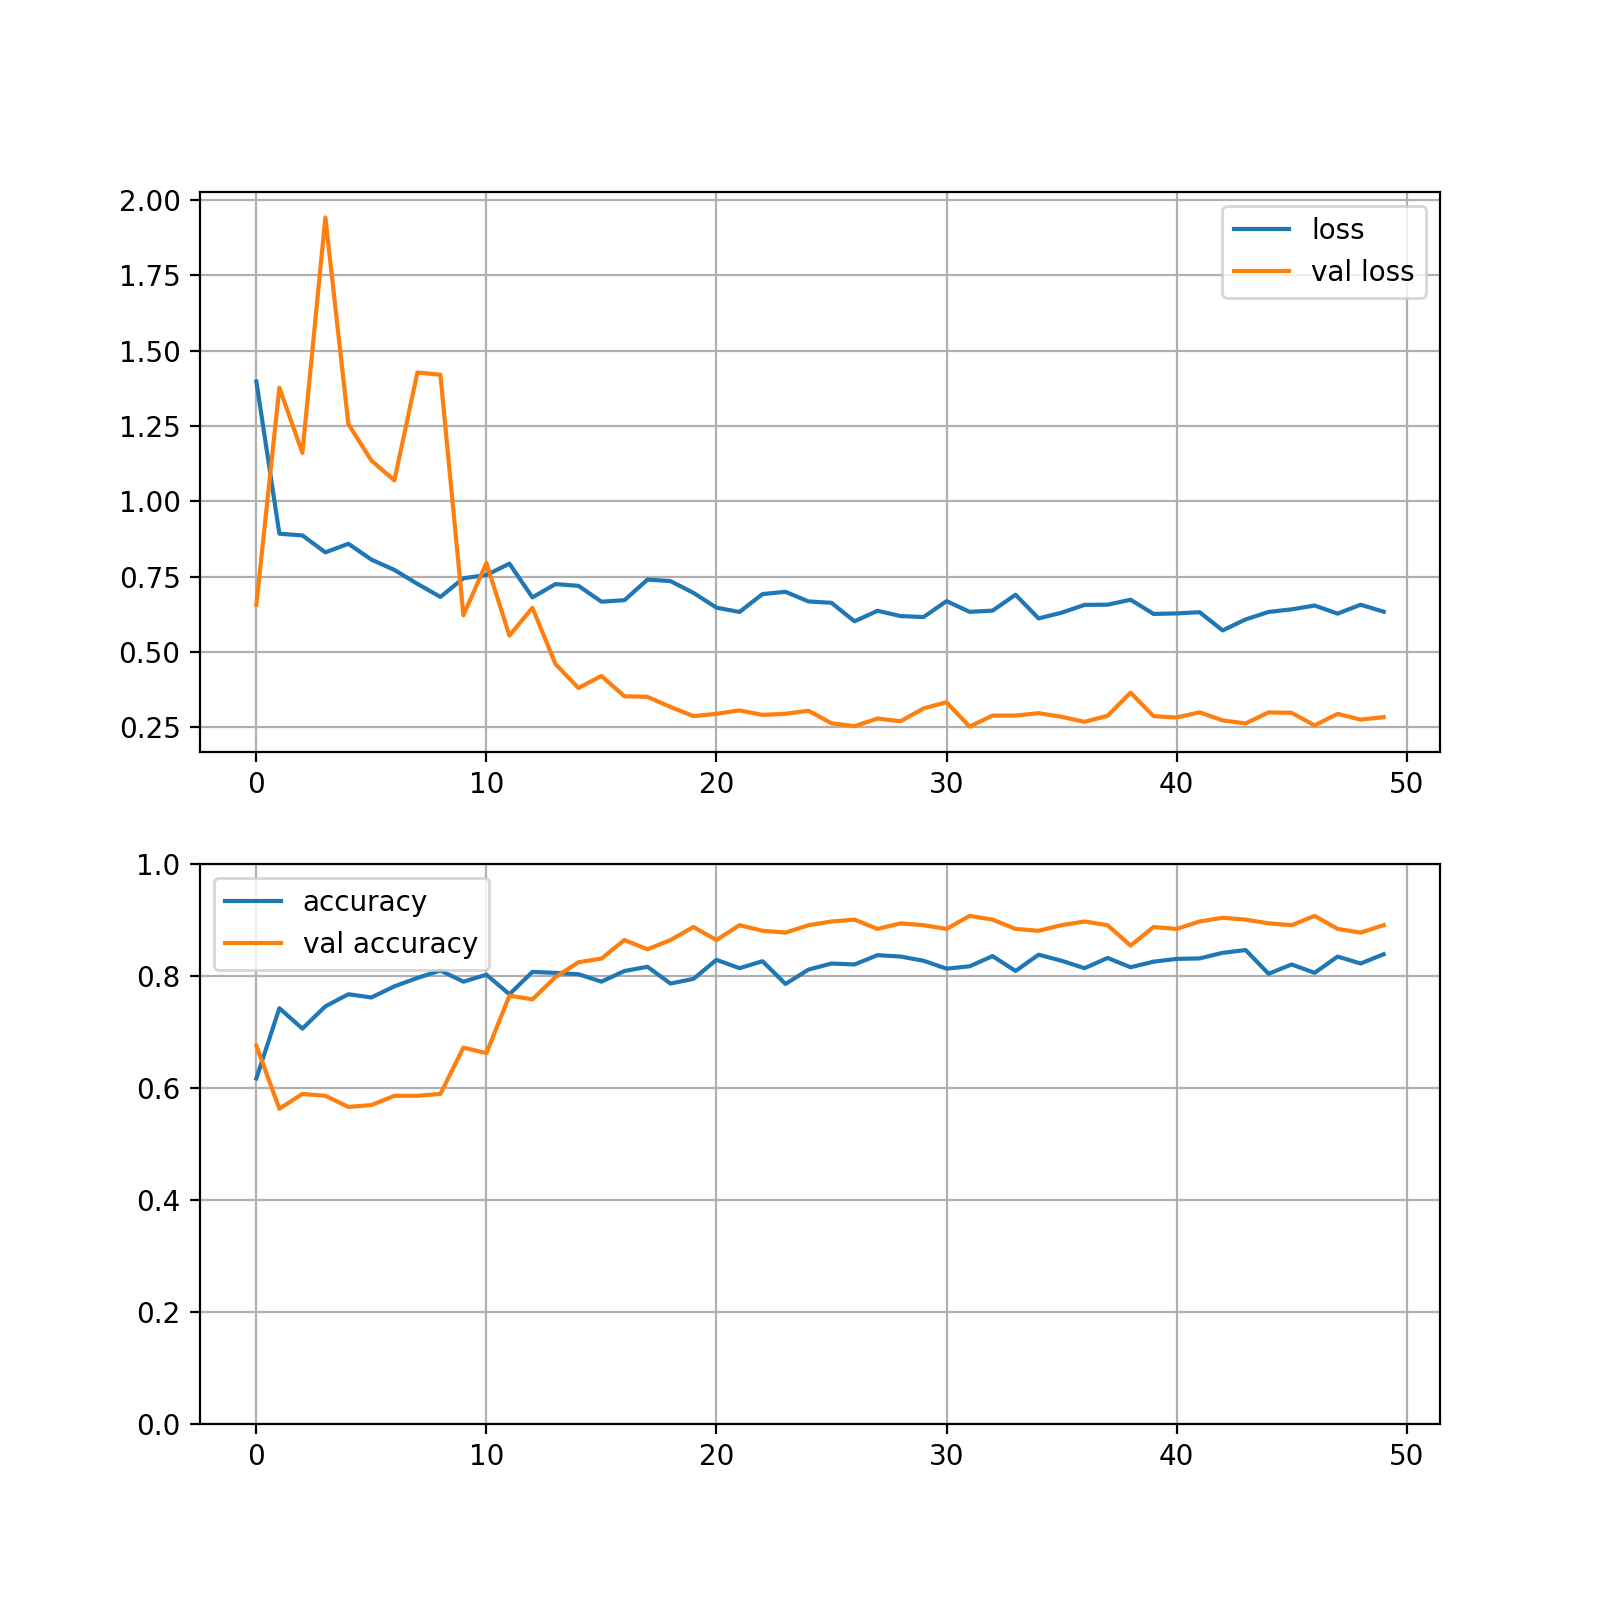

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val loss')
axes[0].grid()
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='accuracy')
axes[1].plot(history.history['val_accuracy'], label='val accuracy')
axes[1].grid()
axes[1].legend()
axes[1].set_ylim(0,1)

fig.savefig('train_performamce.pdf')

In [11]:
res = model.predict(X_test) 

threashold = 0.15
y_pred = decode(res, threshold=threashold)
y_true = decode(y_test, threshold=threashold)

y_pred.sum(), y_true.sum()

(149, 126)

In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       176
           1       0.76      0.90      0.82       126

    accuracy                           0.84       302
   macro avg       0.84      0.85      0.84       302
weighted avg       0.85      0.84      0.84       302



In [13]:
cm = confusion_matrix(y_true, y_pred)

print(cm)
print()
print(cm/cm.sum(axis=1)[:, np.newaxis])

[[140  36]
 [ 13 113]]

[[0.79545455 0.20454545]
 [0.1031746  0.8968254 ]]


<IPython.core.display.Javascript object>


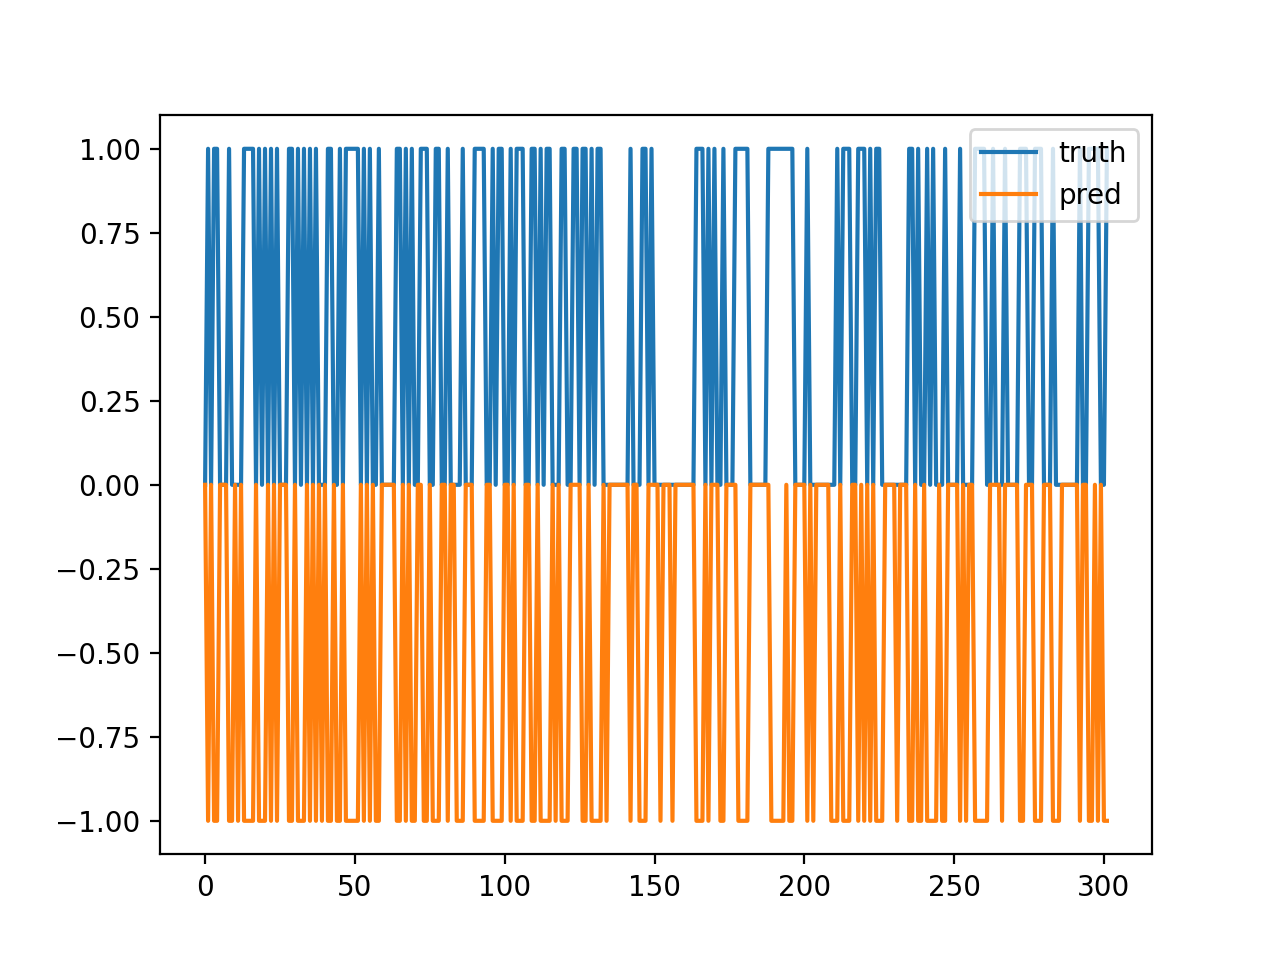

In [14]:
plt.figure()
plt.plot(y_true, label='truth')
plt.plot(-1*y_pred, label='pred')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


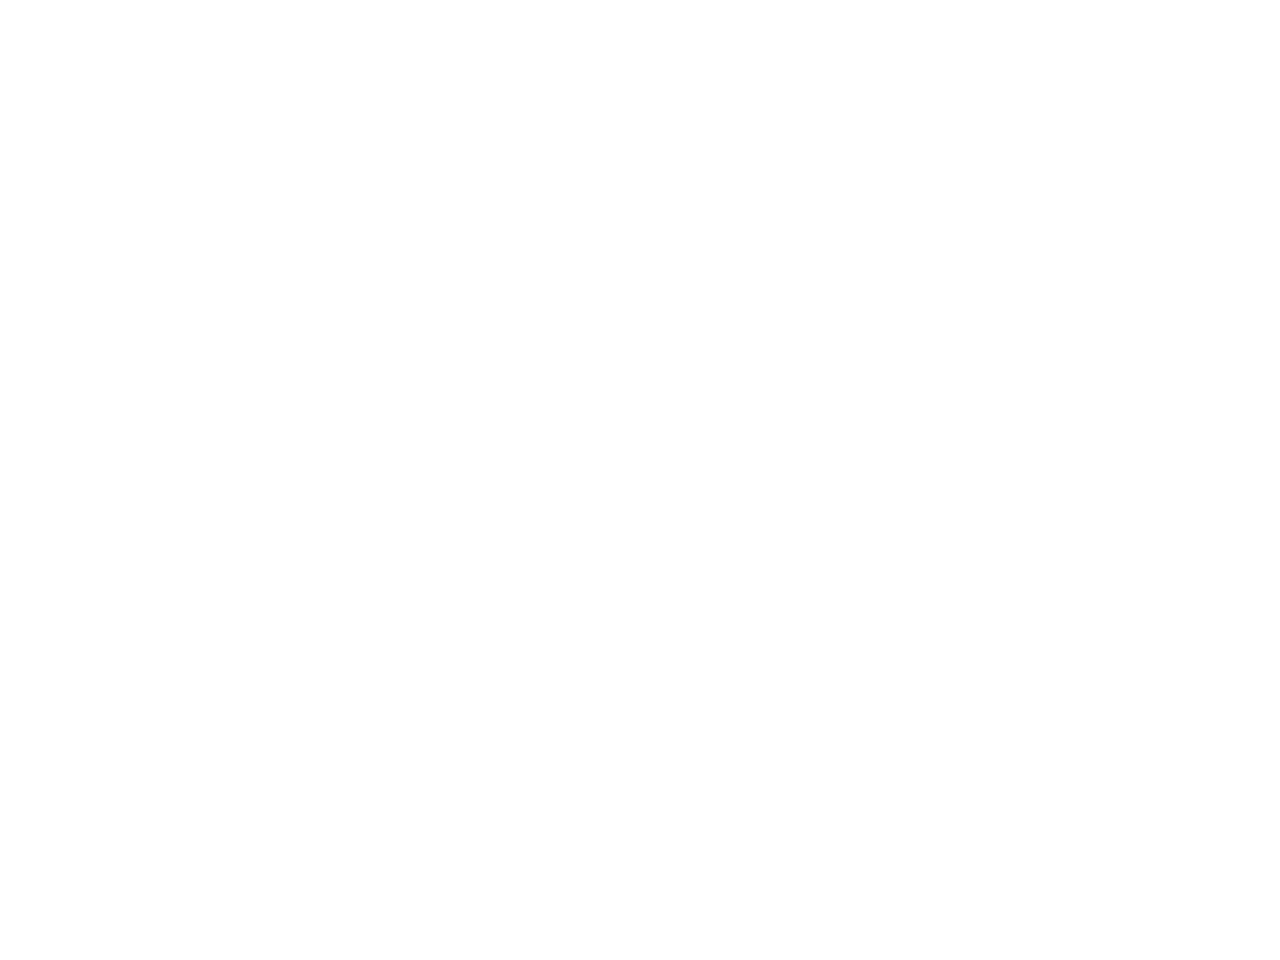

<IPython.core.display.Javascript object>


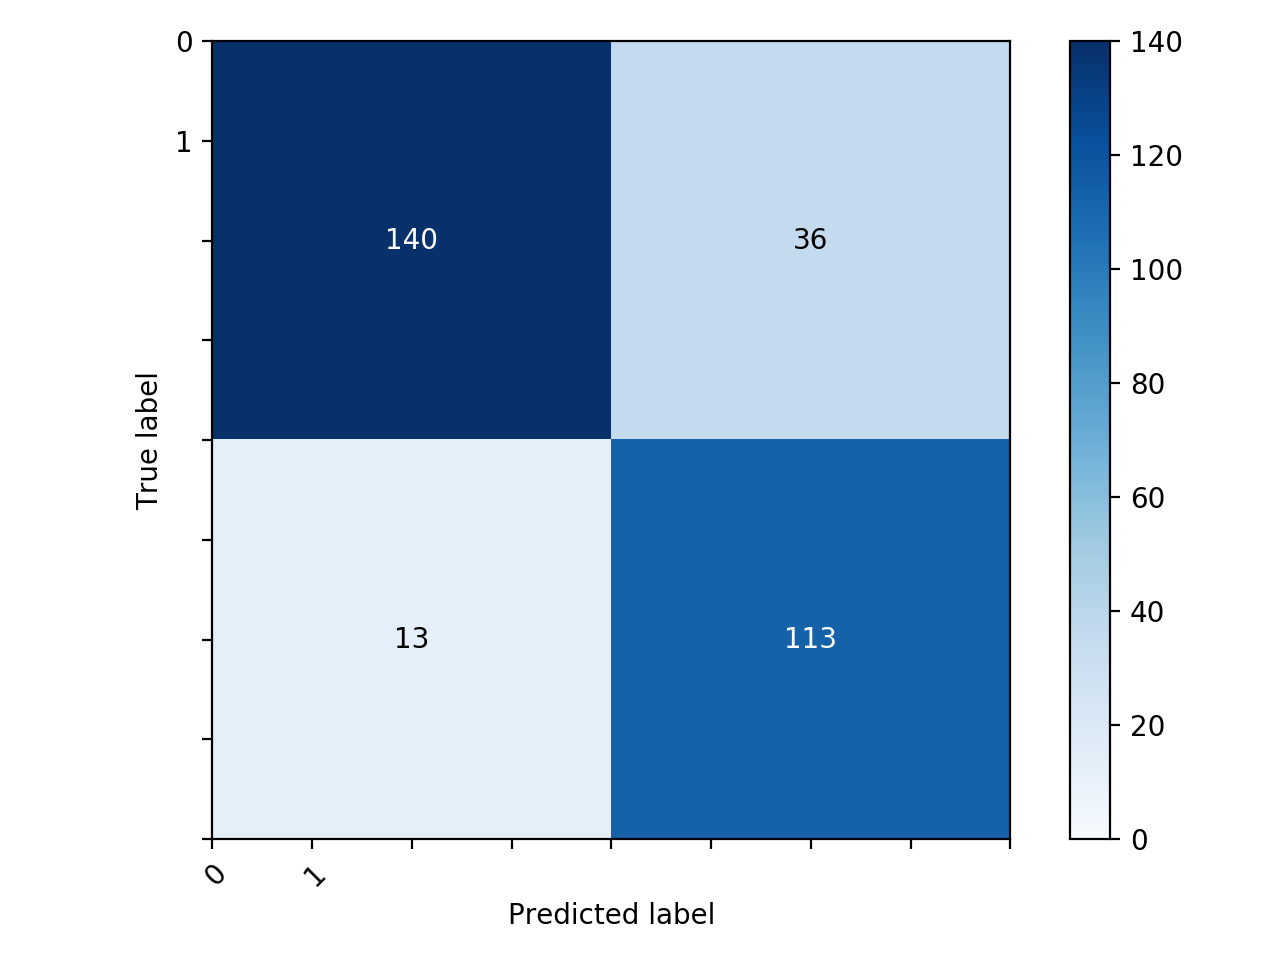

In [20]:
classes = ['0', '1']
cmap=plt.cm.Blues
normalize = False

plt.figure()
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=None)
ax.figure.colorbar(im, ax=ax)
ax.set(#ticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

 # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()


plt.show()